# Autoencoder Model in TensorFlow

## Overview
This Jupyter Notebook is dedicated to building, training, and evaluating an autoencoder using TensorFlow. Autoencoders are a type of neural network used to learn efficient codings of unlabeled data. The goal of this notebook is to demonstrate how to construct an autoencoder for image data compression and reconstruction, focusing on the MNIST dataset, which consists of handwritten digits.

## Objectives
- **Constructing the Autoencoder:** Design an encoder and decoder model using convolutional layers.
- **Training the Model:** Use the MNIST dataset to train the autoencoder, focusing on minimizing reconstruction error.
- **Evaluating the Model:** Assess the performance of the autoencoder by visualizing the reconstruction quality and calculating loss metrics.

## Dataset
The MNIST dataset, which is utilized in this project, includes 70,000 images of handwritten digits (60,000 for training and 10,000 for testing). Each image is grayscale and has a dimension of 28x28 pixels.

## Expected Outcome
By the end of this notebook, we should have a fully trained autoencoder that can compress and decompress images with minimal loss, demonstrating the model's ability to capture the essential features of the input data.


## Data Loading and Preprocessing

In this section, we perform several preprocessing steps on the MNIST dataset to prepare it for use with our autoencoder model:

1. **Data Import:** We start by importing necessary libraries, including TensorFlow, NumPy, Matplotlib for visualization, and various components from `sklearn` for evaluating the model.

2. **Dataset Loading:** Using TensorFlow's Keras API, we load the MNIST dataset, which is automatically split into training and testing sets. The training set includes 60,000 images, and the testing set contains 10,000 images.

3. **Normalization:** We normalize the pixel values of the images to the range [0, 1]. This is a common practice to aid in the convergence of training by providing numerical stability.

4. **Reshaping:** The images in the MNIST dataset are reshaped from 28x28 pixels to 28x28x1, where 1 represents a single-channel grayscale image.

5. **Image Flipping:** For augmentation, we flip the images horizontally and vertically. This step is used here to demonstrate data augmentation techniques that can potentially improve the robustness of the model.

6. **Label Encoding:** The labels are converted to one-hot encoded vectors, which are suitable for classification with TensorFlow's categorical cross-entropy loss function.

These steps collectively format the data appropriately for feeding into the autoencoder for both training and evaluation phases.


In [3]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.losses import mean_squared_error

# Load dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Reshape images to have a single channel
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

# Flip images horizontally and vertically
train_images_flipped = np.flip(train_images, axis=[1, 2])
test_images_flipped = np.flip(test_images, axis=[1, 2])

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

## Visualizing the Data

To better understand the data and the effect of our preprocessing steps, we visualize some of the original and flipped images from both the training and testing sets of the MNIST dataset:

1. **Function Definition - `plot_images`:** We define a function named `plot_images` that takes several parameters:
   - `original_images`: The original images from the dataset.
   - `flipped_images`: The flipped images we created during preprocessing.
   - `labels`: The one-hot encoded labels corresponding to each image.
   - `title`: A title for the plot.
   - `num_images`: The number of images to display, with a default value of 5.

2. **Setting Up the Plot:** Inside the function, we configure a subplot with two rows (one for original images and one for flipped images) and as many columns as the number of images to display. We also set a title for the entire figure.

3. **Displaying Images:** For each image index from 0 to `num_images - 1`, we:
   - Display the original image in the top row with its label.
   - Display the flipped image in the bottom row with the same label.
   - Use grayscale coloring for the images and turn off the axis for a cleaner look.

4. **Plot Execution:** We call the `plot_images` function twice:
   - First, to plot a selection of images from the training set.
   - Second, to plot a selection of images from the testing set.

This visualization allows us to verify the integrity of the data after preprocessing and provides a visual confirmation that the flipping transformation has been applied correctly.


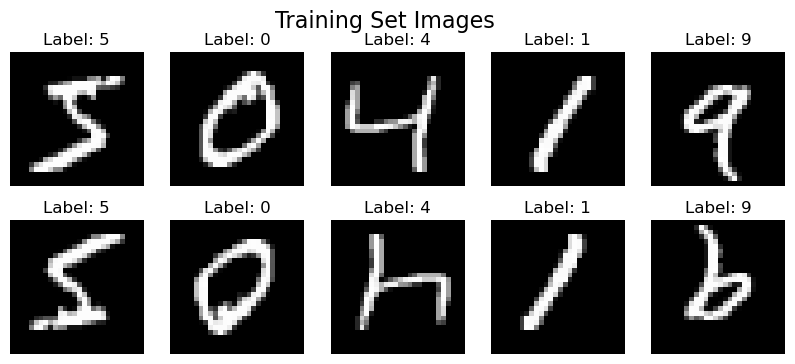

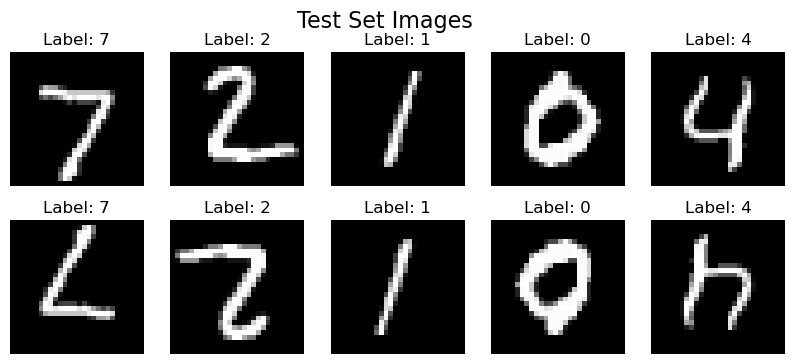

In [4]:
import matplotlib.pyplot as plt

def plot_images(original_images, flipped_images, labels, title, num_images=5):
    fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(10, 4))
    fig.suptitle(title, fontsize=16)
    for i in range(num_images):
        # Display original images
        ax = axes[0, i]
        ax.imshow(original_images[i].reshape(28, 28), cmap='gray')
        ax.set_title(f"Label: {np.argmax(labels[i])}")
        ax.axis('off')

        # Display flipped images
        ax = axes[1, i]
        ax.imshow(flipped_images[i].reshape(28, 28), cmap='gray')
        ax.set_title(f"Label: {np.argmax(labels[i])}")
        ax.axis('off')

    plt.show()

# Plot some training images
plot_images(train_images, train_images_flipped, train_labels, "Training Set Images", num_images=5)

# Plot some test images
plot_images(test_images, test_images_flipped, test_labels, "Test Set Images", num_images=5)


## Model Architecture

In this section, we define the architecture of our autoencoder using TensorFlow's Keras API. The model consists of both an encoder and a decoder:

1. **Input Layer:** The input layer is designed to accept images of shape (28, 28, 1), corresponding to the dimensions of MNIST images.

2. **Batch Normalization:** We apply batch normalization right after the input layer to ensure that the input data has zero mean and unit variance, helping to stabilize training.

### Encoder
The encoder part compresses the input image into a lower-dimensional latent space using a series of convolutional layers:
- **First Convolutional Layer:** Applies 64 filters of size (3x3) with a stride of 1 and padding to maintain the image size.
- **ReLU Activation:** Introduces non-linearity to the encoding process.
- **Max Pooling:** Reduces the spatial dimensions by half using a (2x2) pool size and a stride of 2.
- **Second Convolutional Layer:** Increases the depth to 128 filters while maintaining the image size due to padding.
- **Additional Max Pooling:** Further reduces dimensions with a larger pooling size of (3x3), this time reducing each spatial dimension by a factor of three.
- **Compression Layer:** Further compresses the feature map using 16 filters, preparing the encoded data for the decoding phase.

### Decoder
The decoder part aims to reconstruct the original image from the compressed encoded representation:
- **Conv2D Transpose Layers:** These layers increase the spatial dimensions while reducing depth. We use strides and padding to carefully adjust the output dimensions back to those of the original image.
- **ReLU Activations:** Maintain non-linearity in the decoding process.
- **Upsampling:** Increases the size of the output from the previous layers to match the original image size through learned upsampling.

### Output Layer
- **Final Convolutional Layer:** A single filter with a kernel size of (1x1) is used to reconstruct the final image at the original resolution.

### Model Compilation
- **Optimizer:** Adam optimizer is used for its adaptive learning rate capabilities.
- **Loss Function:** Mean squared error is chosen to quantify the difference between the original and reconstructed images.
- **Metrics:** Accuracy is tracked to monitor reconstruction accuracy during training.

### Model Summary
The `model.summary()` function is called to print a summary of the model, allowing us to verify the architecture and ensure all dimensions align correctly through each layer.

This setup provides a robust framework for an autoencoder that can be trained to learn efficient data codings in an unsupervised manner.


In [5]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Conv2DTranspose, UpSampling2D

# Defining the model
inputs = Input(shape=(28, 28, 1))
x = BatchNormalization()(inputs)

# Encoder
x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(3, 3), padding='same')(x)
x = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(x)
x = Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same')(x)
x = ReLU()(x)
x = UpSampling2D(size=(2, 2))(x)
# Adding this layers to mimic the dimensions of upsampling as done by saving the positions. Tensorflow doesnt have any library to implement that so adding this layer.
x = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='valid')(x)

# Decoder
x = Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)  # use_bias=False if no bias as per the image
x = ReLU()(x)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)  # no bias as per the image

# Final Convolution Layer
outputs = Conv2D(1, (1, 1), strides=(1, 1), padding='same')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with the mean squared error loss
model.compile(optimizer='adam',
                          loss=mean_squared_error,
                          metrics=['accuracy'])

# Print the model summary to verify the output shapes
model.summary()


2024-06-19 23:06:06.759831: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-06-19 23:06:06.759956: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-06-19 23:06:06.759969: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-06-19 23:06:06.760753: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-19 23:06:06.761516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 1)      │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 16)       │        18,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 5, 5, 128)      │        18,560 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 128)    │       409,728 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 14, 14, 64)     │        73,728 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 64)     │        36,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 1)      │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 631,893 (2.41 MB)

 Trainable params: 631,891 (2.41 MB)

 Non-trainable params: 2 (8.00 B)

## TensorBoard Callback Setup

To monitor the training process and evaluate the performance of our model, we use TensorBoard, TensorFlow's visualization toolkit. Here's how we set it up:

1. **Importing TensorBoard:** We import the `TensorBoard` class from TensorFlow's `keras.callbacks` module.

2. **Log Directory:** We define a directory for storing the logs. The directory path includes a timestamp, ensuring that each training session has a unique log directory. This timestamp format includes the year, month, day, hour, and minute of the session's start time.

3. **TensorBoard Callback Configuration:**
   - `log_dir`: Specifies the directory where the logs will be saved.
   - `histogram_freq`: Set to 1 to compute histograms for the weights and biases after each training epoch. This setting helps in visualizing the distribution of weights and biases across different layers over time.

By integrating TensorBoard into our training process, we can access detailed graphical insights into the training and validation metrics, which helps in fine-tuning and debugging the model more effectively.


In [6]:
from tensorflow.keras.callbacks import TensorBoard
import time

log_dir = "logs/fit/" + time.strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


## Model Training

In this section, we execute the training of our autoencoder. Here are the details of the training process:

1. **Training Data:** We provide the original images (`train_images`) as input and the flipped images (`train_images_flipped`) as the target output. This setup is based on our goal to teach the model how to predict the flipped version of an input image.

2. **Epochs:** The model will be trained for 10 epochs. An epoch represents one complete pass of the training data through the model.

3. **Validation Split:** We reserve 20% of the training data for validation. This helps in monitoring the model's performance on unseen data and mitigating overfitting.

4. **Callbacks:** We include the TensorBoard callback configured earlier. This allows us to track and visualize the training process dynamically:
   - Training and validation loss metrics.
   - Histograms of weights and biases to understand how they change over epochs.

By setting these parameters, we aim to train the model effectively while keeping track of various metrics that help us understand the model's learning dynamics. The use of callbacks like TensorBoard enriches the training experience by providing insights into the model's behavior across training epochs.


In [11]:
with tf.device('/cpu:0'):
    
    history = model.fit(
    train_images, 
    train_images_flipped, 
    epochs=10, 
    validation_split=0.2, 
    callbacks=[tensorboard_callback]
    )


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 158s 105ms/step - accuracy: 0.8031 - loss: 0.0405 - val_accuracy: 0.8134 - val_loss: 0.0179
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 173s 115ms/step - accuracy: 0.8126 - loss: 0.0162 - val_accuracy: 0.8137 - val_loss: 0.0134
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 190s 126ms/step - accuracy: 0.8138 - loss: 0.0123 - val_accuracy: 0.8148 - val_loss: 0.0105
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 184s 123ms/step - accuracy: 0.8143 - loss: 0.0104 - val_accuracy: 0.8152 - val_loss: 0.0094
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 186s 124ms/step - accuracy: 0.8145 - loss: 0.0093 - val_accuracy: 0.8153 - val_loss: 0.0088
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 187s 125ms/step - accuracy: 0.8140 - loss: 0.0085 - val_accuracy: 0.8155 - val_loss: 0.0081
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 186s 124ms/step - accuracy: 0.8148 - loss: 0.0079 - val_accuracy: 0.8156 - val_loss: 0.0076
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 191s 127ms/step - ac

## Evaluation of Training Outcomes

To assess the performance of our autoencoder, we visualize the training and validation losses and review the final MSE values:

1. **Loss Visualization:**
   - We plot the mean squared error (MSE) for both the training and validation datasets across each epoch. This plot helps us understand how the model's error decreases over time, which is crucial for confirming the learning process.
   - The `plt.plot` function is used to create the line graphs for both training and validation losses.
   - Labels, title, and legends are added to enhance the readability and interpretability of the plot.

2. **Final MSE Values:**
   - After the training process, we extract and print the final MSE values for both the training and validation sets. These values provide a quantitative measure of how well the model has learned to reconstruct the input images.
   - If validation data was used (which is recommended to monitor overfitting), the final MSE for the validation set is also displayed.

This step is essential for evaluating the effectiveness of the autoencoder in minimizing reconstruction error, which directly relates to its performance on unseen data if validation was performed.


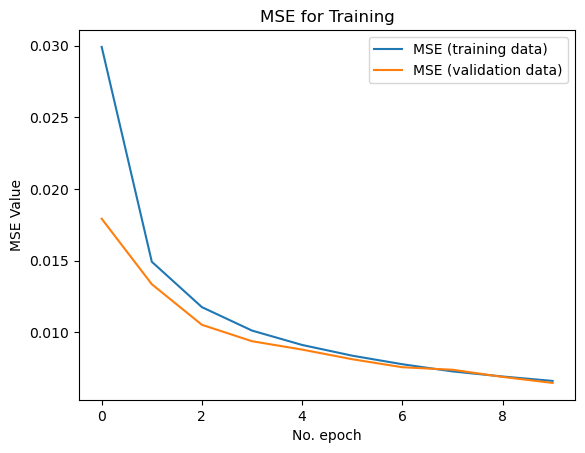

The final MSE value achieved on the training set: 0.0066
The final MSE value achieved on the validation set: 0.0065


In [12]:
import matplotlib.pyplot as plt

# Plot the training loss
plt.plot(history.history['loss'], label='MSE (training data)')
plt.plot(history.history.get('val_loss', []), label='MSE (validation data)')  # Optional if validation_split used
plt.title('MSE for Training')
plt.ylabel('MSE Value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

# Print the final MSE value for the training set
final_mse_train = history.history['loss'][-1]
print(f"The final MSE value achieved on the training set: {final_mse_train:.4f}")

if 'val_loss' in history.history:
    final_mse_val = history.history['val_loss'][-1]
    print(f"The final MSE value achieved on the validation set: {final_mse_val:.4f}")


## Visualization of Model Reconstructions

To assess the quality of the autoencoder's reconstructions, we visualize the original and reconstructed images for each unique digit from both the training and testing sets. The following steps detail the process:

1. **Label Conversion:** We convert the one-hot encoded labels back to integer labels for simplicity and ease of indexing.

2. **Indexing Unique Digits:** For each unique digit in the dataset, we find one representative index in both the training and testing sets. This allows us to consistently visualize the reconstruction of the same digit across different sets.

3. **Model Predictions:**
   - We use the trained model to predict (reconstruct) the images from the original training and testing sets.
   - This step generates the reconstructed images based on the learned features during training.

4. **Visualization Setup:**
   - We create subplots to display the original and reconstructed images side by side for direct comparison.
   - Each unique digit has its section in the figure, with separate subplots for the original and reconstructed images from both the training and testing datasets.

5. **Plotting Images:**
   - For each digit, the original image and its reconstruction from the training set are displayed first.
   - This is followed by the original and reconstructed images from the test set.
   - Each image is displayed with its respective label indicating whether it's an original or reconstructed image and whether it's from the training or testing set.

6. **Figure Adjustments:**
   - The layout is adjusted for better visibility and organization, ensuring that each subplot is clearly separated and labeled.

This visualization not only provides insight into how well the autoencoder is performing but also highlights any potential issues with specific digits or sets, guiding further improvements in the model architecture or training process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


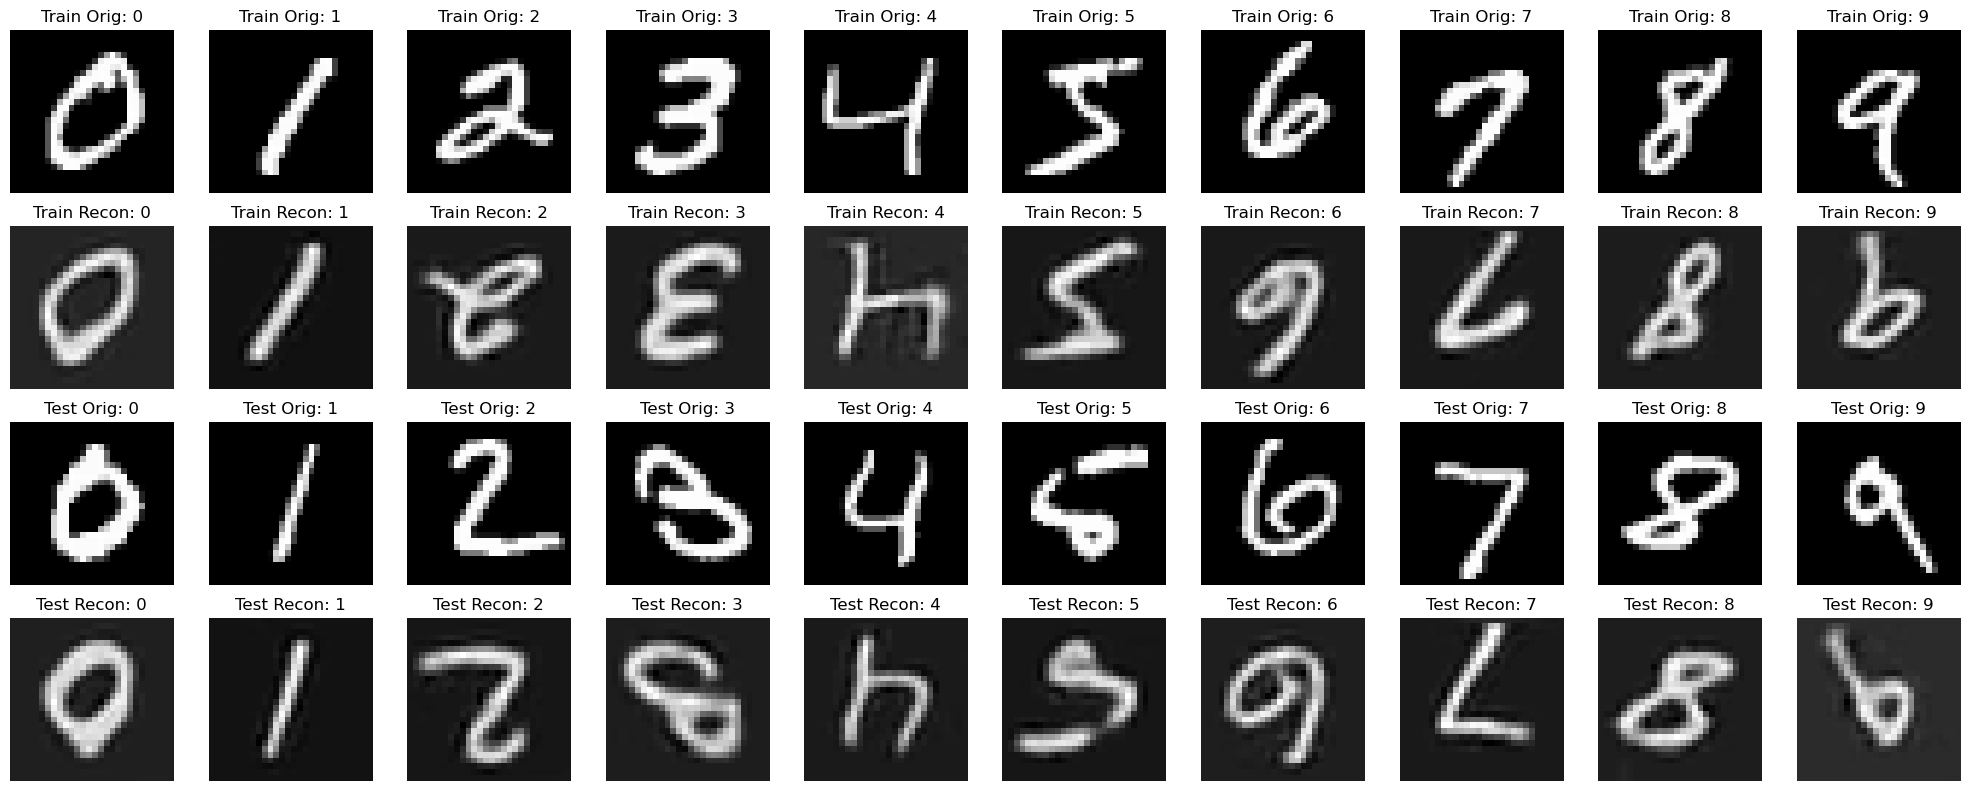

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Convert one-hot encoded labels to integer labels for both training and test sets
train_integer_labels = np.argmax(train_labels, axis=1)
test_integer_labels = np.argmax(test_labels, axis=1)

unique_digits = np.unique(train_integer_labels)  # Assuming the same digits are in both sets
indices_per_digit_train = {}
indices_per_digit_test = {}

# Find one index for each unique digit in training and test sets
for digit in unique_digits:
    indices_per_digit_train[digit] = np.where(train_integer_labels == digit)[0][0]
    indices_per_digit_test[digit] = np.where(test_integer_labels == digit)[0][0]

# Generate reconstructions for both training and test sets using the trained autoencoder
reconstructed_train_images = model.predict(train_images)
reconstructed_test_images = model.predict(test_images)

# Plot the original and reconstructed images from both training and test sets
plt.figure(figsize=(20, 8))
for i, digit in enumerate(sorted(unique_digits)):
    train_idx = indices_per_digit_train[digit]
    test_idx = indices_per_digit_test[digit]

    # Training original images
    plt.subplot(4, len(unique_digits), i + 1)
    plt.imshow(train_images[train_idx].reshape(28, 28), cmap='gray')
    plt.title(f'Train Orig: {digit}')
    plt.axis('off')

    # Training reconstructed images
    plt.subplot(4, len(unique_digits), len(unique_digits) + i + 1)
    plt.imshow(reconstructed_train_images[train_idx].reshape(28, 28), cmap='gray')
    plt.title(f'Train Recon: {digit}')
    plt.axis('off')

    # Test original images
    plt.subplot(4, len(unique_digits), 2 * len(unique_digits) + i + 1)
    plt.imshow(test_images[test_idx].reshape(28, 28), cmap='gray')
    plt.title(f'Test Orig: {digit}')
    plt.axis('off')

    # Test reconstructed images
    plt.subplot(4, len(unique_digits), 3 * len(unique_digits) + i + 1)
    plt.imshow(reconstructed_test_images[test_idx].reshape(28, 28), cmap='gray')
    plt.title(f'Test Recon: {digit}')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Calculation of Mean Squared Error by Digit

To further evaluate the performance of our autoencoder across different types of inputs, we calculate the mean squared error (MSE) for each digit in the MNIST dataset. This step allows us to identify how well the model reconstructs each specific digit, potentially highlighting areas where the model may need improvement.

### Function Definition
- **Function `mse_per_digit`**: This function calculates the MSE for each digit (0-9). It takes three parameters:
  - `images`: The set of images (either training or testing).
  - `one_hot_labels`: The one-hot encoded labels for these images.
  - `model`: The trained model used for predictions.
- The function converts one-hot labels to integer labels, predicts the reconstructed images using the model, and then computes the MSE between the original and reconstructed images for each digit.

### MSE Calculation
- We apply the `mse_per_digit` function separately to both the training and testing datasets to obtain the MSE scores for each digit.

### Output
- **Print MSE Scores**: The calculated MSE scores for each digit are printed for both training and testing sets.
- **Identifying the Best-Performing Digits**:
  - We identify and print the digit with the lowest MSE for both the training and testing sets. The lowest MSE indicates the best reconstruction performance by the autoencoder for that particular digit.

This detailed analysis of MSE by digit not only provides insights into the model's performance but also helps in understanding which digits are easier or harder for the model to reconstruct accurately, guiding potential targeted improvements in the training process or model architecture.


In [14]:
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error

# Function to calculate MSE for each digit
def mse_per_digit(images, one_hot_labels, model):
    labels = np.argmax(one_hot_labels, axis=1)  # Convert one-hot encoded labels to integers
    mse_scores = {}
    for digit in range(10):
        digit_indices = np.where(labels == digit)[0]
        digit_images = images[digit_indices]
        reconstructed_images = model.predict(digit_images)
        mse_scores[digit] = mean_squared_error(digit_images.reshape(-1), reconstructed_images.reshape(-1))
    return mse_scores

# Calculate MSE for each digit
train_mse_scores = mse_per_digit(train_images, train_labels, model)
test_mse_scores = mse_per_digit(test_images, test_labels, model)

# Print MSE scores
print("Training MSE Scores:", train_mse_scores)
print("Testing MSE Scores:", test_mse_scores)

# Determine the digit with the lowest MSE in both sets
min_train_mse_digit = min(train_mse_scores, key=train_mse_scores.get)
min_test_mse_digit = min(test_mse_scores, key=test_mse_scores.get)

print(f"Digit with lowest MSE on Training Set: {min_train_mse_digit} with MSE {train_mse_scores[min_train_mse_digit]}")
print(f"Digit with lowest MSE on Test Set: {min_test_mse_digit} with MSE {test_mse_scores[min_test_mse_digit]}")


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training MSE Scores: {0: 0.12944932, 1: 0.04536155, 2: 0.1309177, 3: 0.12392927, 4: 0.103318736, 5: 0.11958719, 6: 0.12865447, 7: 0.13223983, 8: 0.11369968, 9: 0.10764907}
Testing MSE Scores: {0: 

On both training set and test set digit 1 has the lowest MSE.

## Visualization of Layer Activations

Understanding the intermediate representations learned by the autoencoder can provide valuable insights into what the model is actually learning and how it is processing the input data. Here's how we extract and analyze these activations:

### Intermediate Layer Model
- **Layer Selection**: We select the output of the 10th layer of our model. This layer is chosen because it represents a significant transformation within the encoder, before the image is fully compressed into the latent space.
- **Model Creation**: We create a new model (`intermediate_layer_model`) that uses the same input as our original model but outputs the activations from the selected intermediate layer.

### Activation Extraction
- **Prediction**: Using the `predict` method, we compute the activations for all images in the training set.
- **Flattening**: Since the activations are in the format of multi-dimensional arrays, we flatten them into vectors. This makes it easier to handle and visualize the data. Here, we assume the layer's output dimensions are 5x5x16.

### Visualization
- **Histograms**: We plot histograms for the first five features of the flattened activations. This visualization helps in understanding the distribution of activation values across the dataset for these features.
- **Subplots**: Each feature gets its own subplot for clarity, and we use 50 bins in each histogram to capture detailed distribution characteristics.

This analysis is crucial for diagnosing model behavior, particularly to check if certain features are not activating at all (which might suggest dead filters) or if some features have particularly strong activations, which could dominate the learning process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


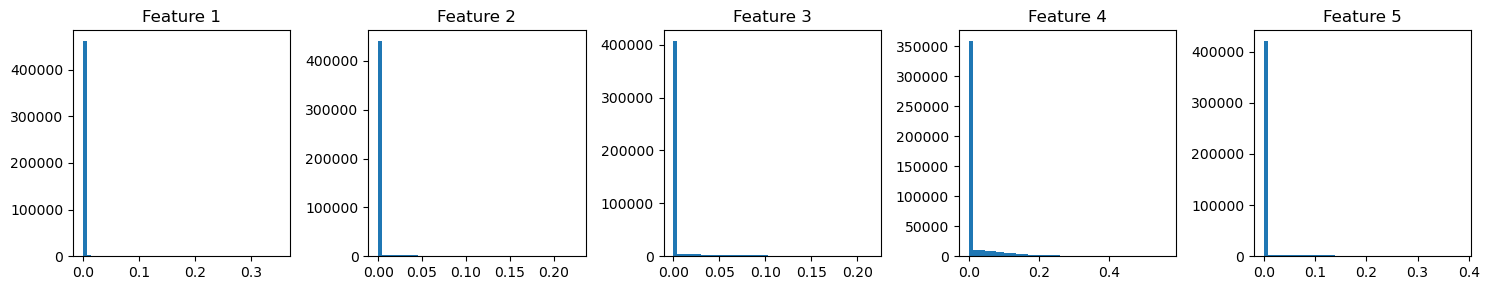

In [15]:
layer_output = model.layers[10].output

# Create a model that will return these outputs, given the model input
intermediate_layer_model = Model(inputs=model.input, outputs=layer_output)

# Get the activations for all training images
activations = intermediate_layer_model.predict(train_images)

# Flatten the activations to vectors of length 400 (5*5*16)
flattened_activations = activations.reshape(-1, 5*5*16)

# Plot the histograms for the first five features
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.hist(flattened_activations[:, i], bins=50)
    plt.title(f'Feature {i+1}')
plt.tight_layout()
plt.show()


## Statistical Analysis and Synthesis of Activations

To deepen our understanding of the model's internal representations, we conduct a statistical analysis on the activations from an intermediate layer and compare them to synthetically generated data. Here’s a step-by-step breakdown:

### Intermediate Layer Analysis
- **Layer Extraction**: We select the output of the 10th layer of the model, which is expected to carry significant feature transformations.
- **Model for Layer Output**: A new model (`intermediate_layer_model`) is created that will output the activations of this specific layer, given the same inputs as the original model.
- **Activation Prediction**: Using the new model, we predict activations for all images in the training set.

### Statistical Measures
- **Flattening**: The multi-dimensional activation arrays are flattened to simplify the calculation of statistical measures.
- **Mean and Variance Calculation**: We compute the mean and variance for the first five features in the flattened activations to capture their central tendency and dispersion.
- **Covariance Matrix**: The covariance matrix for these features is also computed, which helps in understanding how these features vary together.

### Synthetic Data Generation
- **Gaussian Random Vectors**: Based on the calculated mean and covariance matrix, we generate Gaussian random vectors. This synthetic data helps in comparing the model's activations to a standard statistical model.

### Visualization and Comparison
- **Histograms**: For each of the first five features, we plot histograms of both the actual activations and the generated Gaussian random vectors.
  - The actual activations are displayed in the top row.
  - The synthetically generated data is shown in the bottom row, allowing for a visual comparison.
- **Titles and Legends**: Each plot is properly titled and includes a legend to differentiate between the actual and generated data.

### Output Statistics
- **Printing Statistical Measures**: After visualization, we print the means, variances, and the covariance matrix for the first five features. This provides a textual understanding of the data characteristics.

This comprehensive analysis not only aids in verifying the diversity and complexity of the learned features but also checks whether the activations resemble a normal distribution, which can be indicative of well-trained features in some contexts.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


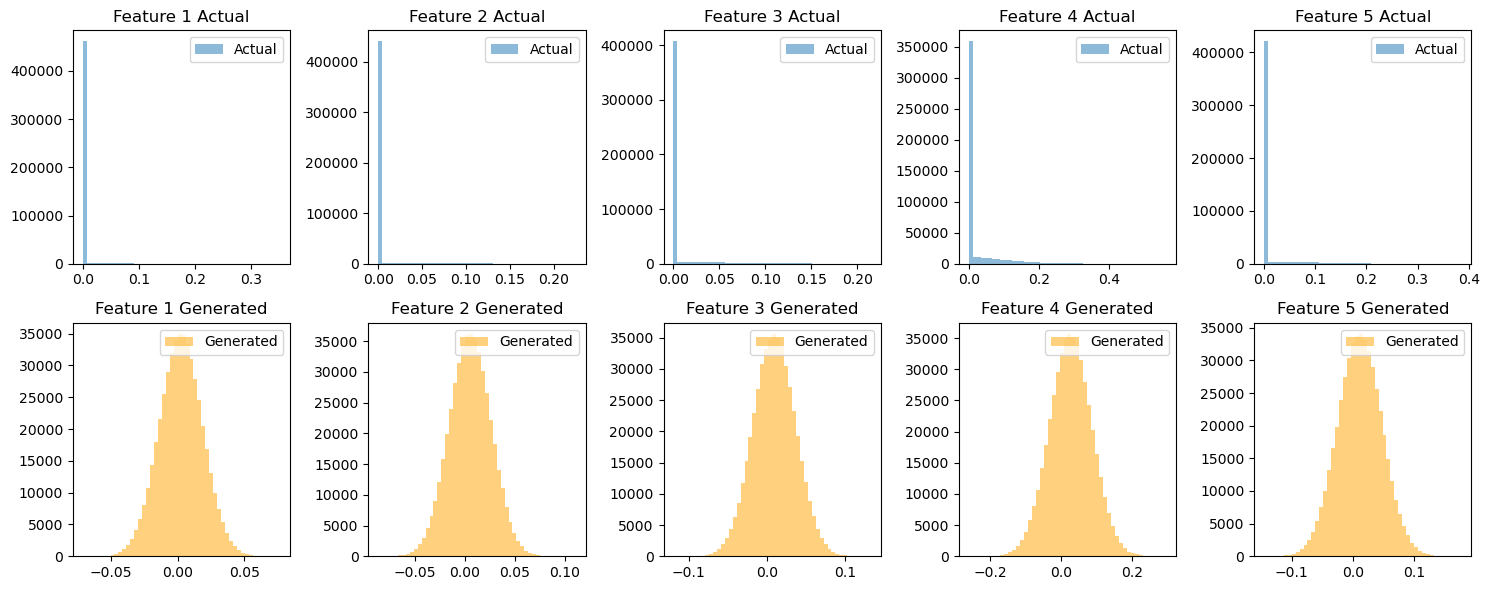

Means of the first five features: [0.00260099 0.00512231 0.00924629 0.02641475 0.0110801 ]
Variances of the first five features: [0.00026391 0.00043706 0.0007382  0.00356101 0.001297  ]
Covariance matrix of the first five features:
 [[ 2.63205880e-04 -1.30567799e-05 -2.25255400e-05  2.31785330e-04
  -2.71850960e-05]
 [-1.30567799e-05  4.36375183e-04  9.53879941e-06 -6.63395900e-05
  -5.60916398e-05]
 [-2.25255400e-05  9.53879941e-06  7.35363405e-04 -1.68229978e-04
  -8.60638098e-05]
 [ 2.31785330e-04 -6.63395900e-05 -1.68229978e-04  3.55576857e-03
  -4.53312016e-06]
 [-2.71850960e-05 -5.60916398e-05 -8.60638098e-05 -4.53312016e-06
   1.29760572e-03]]


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Get the output of the 10th layer of the model
layer_output = model.layers[10].output

# Create a new model that returns the output of the 10th layer
intermediate_layer_model = Model(inputs=model.input, outputs=layer_output)

# Predict the activations using the new model
activations = intermediate_layer_model.predict(train_images)

# Flatten the activations
flattened_activations = activations.reshape(-1, 5*5*16)

# Calculate the mean and variance for the first five features
means = flattened_activations[:, :5].mean(axis=0)
variances = flattened_activations[:, :5].var(axis=0)

# Calculate the covariance matrix for the first five features
covariance_matrix = np.cov(flattened_activations[:, :5].T)

# Generate the Gaussian random vectors
random_vectors = np.random.multivariate_normal(means, covariance_matrix, size=flattened_activations.shape[0])

# Plot histograms for the activations and the Gaussian random vectors
plt.figure(figsize=(15, 6))
for i in range(5):
    # Plotting the actual feature activations
    plt.subplot(2, 5, i + 1)
    plt.hist(flattened_activations[:, i], bins=50, alpha=0.5, label='Actual')
    plt.title(f'Feature {i+1} Actual')
    plt.legend()

    # Plotting the Gaussian random vectors
    plt.subplot(2, 5, i + 6)
    plt.hist(random_vectors[:, i], bins=50, alpha=0.5, color='orange', label='Generated')
    plt.title(f'Feature {i+1} Generated')
    plt.legend()

plt.tight_layout()
plt.show()

# Print the means and variances
print('Means of the first five features:', means)
print('Variances of the first five features:', variances)
print("Covariance matrix of the first five features:\n", covariance_matrix)

## Analysis of Feature Activations

### Shape of the Distributions
- The **actual** feature activations are highly concentrated around specific values, as indicated by the narrow peaks in the histograms. This could suggest that the features are either:
  - Not being activated by the variations in the input data (if peaks are near zero).
  - Consistently activated across different inputs (if peaks are away from zero).

- The **generated** features, on the other hand, display a Gaussian distribution, characterized by their bell-shaped histograms.

### Mean and Variance
- The provided means of the actual features are relatively low, suggesting that the neurons are not highly activated on average.
- The variances are quite small, corresponding with the narrow distribution peaks, indicating a lack of diversity in the neuron activations.

### Comparison of Actual vs. Generated Data
- The histograms of the actual data show very limited spread, with values clustered at or near specific points.
- The generated data has a typical Gaussian spread, which is not observed in the actual feature activations.
- This indicates a significant difference between the actual feature activations and what would be expected if they followed a Gaussian distribution.

